# Frame the problem, and look at the big picture

Analyzing hand written digits and letters by hand is very time consuming, and by automaing the process with the use of machine learning, the postal office can save recources in manpower and money. 

In this notebook we are going to analyze a dataset of hand written digits, and in the end be able to predict the label of the given hand written digit. We are given a dataset that contains images, and the first half of this notebook will be spent getting the data, extracting informaion from the data and then preprocessing it for further analysis by our models.

## Setup

In [1]:
#!pip install lightgbm
import os
import time
import numpy as np
seed = 42
np.random.seed(seed)

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette("GnBu_d")

%matplotlib inline

from sklearn import model_selection, preprocessing, metrics
from sklearn.model_selection import GridSearchCV

from keras import backend
from keras.models import Sequential
from keras.losses import categorical_crossentropy
from keras.callbacks import LearningRateScheduler
from keras.optimizers import SGD, Adam
from keras.utils import to_categorical
from keras.layers import Dense, BatchNormalization

import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=FutureWarning)
warnings.filterwarnings(action='ignore', category=DataConversionWarning)


Using TensorFlow backend.


# Get the data

In [2]:
images = 'handwritten_digits_images.csv'
labels = 'handwritten_digits_labels.csv'
X = pd.read_csv(images, header=None)
y = pd.read_csv(labels, header=None)

# Explore the data to gain insights

In [3]:
print(X.head())
print(y.head())

   0    1    2    3    4    5    6    7    8    9    ...  774  775  776  777  \
0    0    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
1    0    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
2    0    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
3    0    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
4    0    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   

   778  779  780  781  782  783  
0    0    0    0    0    0    0  
1    0    0    0    0    0    0  
2    0    0    0    0    0    0  
3    0    0    0    0    0    0  
4    0    0    0    0    0    0  

[5 rows x 784 columns]
   0
0  0
1  0
2  0
3  0
4  0


Here we see that the data is not optimized for visualisation, so we need to reshape it for visualization. We use pyplot in order to show the image, and to check if it is correct we print out the corresponding label

9


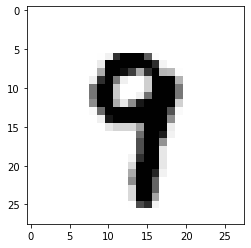

In [4]:
X_data = X.values.reshape(X.shape[0], 28, 28)

image_index = 69000
print(y.iat[image_index, 0])
plt.imshow(X_data[image_index], cmap='Greys')

##### As this is an image dataset, there is not much insight to gain, but we will extract what we can, firstly, we can look at the distribution of labels

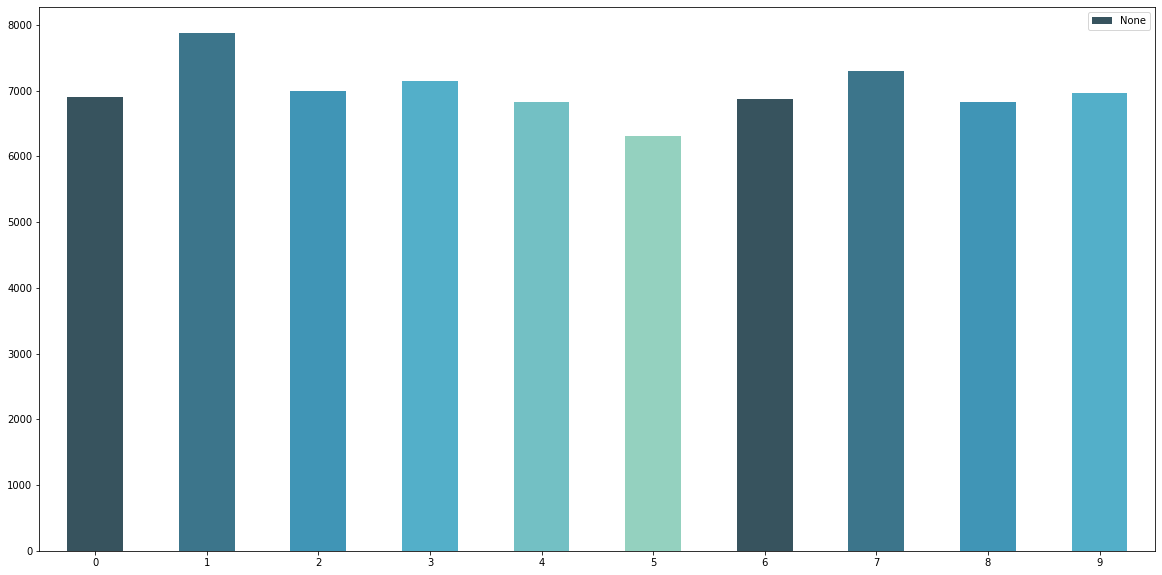

In [5]:
axes = plt.subplots(figsize=(20,10))
pd.value_counts(y.values.flatten(), sort=False).plot(kind="bar", rot=0, legend="Label", color=color)

As we can see, it seems like it is pretty evenly distributed, so we won't need for example a majoriy classifier later on. We can also check what datatype our values are. This will be useful as we might have to do mathematical operations on the dataset in order to make it model-friendly

In [6]:
print(type(X_data[image_index]))
print(type(y.iat[image_index, 0]))

<class 'numpy.ndarray'>
<class 'numpy.int64'>


Its also nice to know what shape we have for debugging purposes

In [7]:
print(X.shape)
print(y.shape)

(70000, 784)
(70000, 1)


Lastly, we check if there are any null values. Since this is quite the clean dataset, we dont need to worry with replacing any values.

In [8]:
print(X.isnull().sum())

0      0
1      0
2      0
3      0
4      0
      ..
779    0
780    0
781    0
782    0
783    0
Length: 784, dtype: int64


# Prepare the data to better expose the underlying data patterns to machine learning algorithms

Firstly we need to reshape the data in order for it to be usable by the different models, and we also need to split the data into train and test datasets. We do that split twice in order to get a validation set. We also reshape the data to work with the neural network.

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state = seed)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size= 0.2, random_state = seed)

#reshaping to work with keras
X_train_rs = X_train.values.reshape(X_train.shape[0], 28, 28, 1)
X_test_rs = X_test.values.reshape(X_test.shape[0], 28, 28, 1)
X_val_rs= X_val.values.reshape(X_val.shape[0], 28, 28, 1)

To be able to normalize the data, we need to make it possible to divide it

In [10]:
#change reshaped values to floats
X_train_rs = X_train_rs.astype('float32')
X_test_rs = X_test_rs.astype('float32')
X_val_rs= X_val_rs.astype('float32')

Here we divide by the max RGB code to normalize it

In [11]:
#Normalizing
X_train_rs /= 255
X_test_rs /= 255
X_val_rs /= 255

We also need to one-hot encode our labels in order to use them with keras

In [12]:
#one-hot encoding
y_train_oh = to_categorical(y_train)
y_test_oh = to_categorical(y_test)
y_val_oh = to_categorical(y_val)

# Explore different models and short-list the best ones

To start with, we will use an easy-to-implement model, such as DecisionTreeClassifier from Sklearn, but first we need to import some metrics to see how our models perform

In [13]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

In [14]:
from sklearn.tree import DecisionTreeClassifier
decision_tree = DecisionTreeClassifier(random_state=seed)
decision_tree.fit(X_train, y_train)
y_ = decision_tree.predict(X_test)

In [15]:
accuracy_score(y_test,y_)

0.8652142857142857

As we can see, it performs ok for a model without tuning, and is considerably faster than if we had to label by hand(alebit a human would probably have a better accuracy), but we can do better. Firstly we will create a couple more models with basic configuration and no hyper-parameter tuning, then in the next part we will implement model-selection and hyper-parameter tuning. The models we will implement next are: RandomForestClassifier, Keras NN(will switch to CNN in the next part), and LightGBMClassifier(Light gradient boosted machine)

In [16]:
from sklearn.ensemble import RandomForestClassifier
random_forest = RandomForestClassifier(random_state=seed)
random_forest.fit(X_train, y_train)
y_ = random_forest.predict(X_test)

In [17]:
accuracy_score(y_test, y_)

0.9411428571428572

Here we use a simple keras neural network, and in order to get the correct output shape, we need to flatten it

In [19]:
from keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
model = Sequential()
model.add(Dense(784, activation="relu", input_shape = X_train_rs[0].shape))
model.add(Flatten())
model.add(Dense(10, activation="softmax"))
model.compile(loss=categorical_crossentropy, optimizer=SGD(0.1), metrics=['accuracy'])

history = model.fit(X_train_rs, y_train_oh, batch_size = 16, epochs = 5)
y_ = model.predict(X_test_rs)

Epoch 1/5
44800/44800 [==============================] - 336s 7ms/step - loss: 0.3866 - accuracy: 0.8876
Epoch 2/5
44800/44800 [==============================] - 331s 7ms/step - loss: 0.3145 - accuracy: 0.9118
Epoch 3/5
44800/44800 [==============================] - 332s 7ms/step - loss: 0.2993 - accuracy: 0.9156
Epoch 4/5
44800/44800 [==============================] - 380s 8ms/step - loss: 0.2919 - accuracy: 0.9182
Epoch 5/5
44800/44800 [==============================] - 461s 10ms/step - loss: 0.2851 - accuracy: 0.9192


In [20]:
from keras.metrics import accuracy
print(model.evaluate(X_test_rs, y_test_oh))

14000/14000 [==============================] - 38s 3ms/step
[0.3129837729845728, 0.915071427822113]


You could try to run the code below to use XGBoost Classifier, but on multiclass classification it seems that the time increases quadratically with the number of classes(took me ish 1 hour to run on my desktop computer). Instead we will use LightGBM which is also a gradient boosted machine.

In [20]:
#from xgboost import XGBClassifier
#model = XGBClassifier()
#model.fit(X_train, y_train)

#print(model)

#y_ = model.predict(X_test)

In [ ]:
%%time

import lightgbm as lgbm
model = lgbm.LGBMClassifier(objective='multiclass',silent=False, random_state = seed)
model.fit(X_train, y_train)
y_ = model.predict(X_test)

print(model)

In [ ]:
print(accuracy_score(y_test, y_))

Pretty good score here! But we can make it better

# Fine-tune models and combine them to a good solution

This section is all about fine tuning our models, as well as selecting the best one. We are going to implement model selection, as well as an "ensemble" of all our models into one to see if it gives us the highest score in this notebook. Firstly we will see how we can improve RandomForest and DecisionTree, then we will make a Convolutional Neural-Network with keras, and lastly do some fine tuning on the hyper parameters for LightGBM. We start out by implementing kfolds cross validation.

In [23]:
def KFold_split(X, Y, num_folds, seed):
    KFold_splitter = KFold(n_splits=num_folds, shuffle=True, random_state=seed)
    X_train_folds = []
    X_val_folds = []
    Y_train_folds = []
    Y_val_folds = []
    for (kth_fold_train_idxs, kth_fold_val_idxs) in KFold_splitter.split(X, Y):
        X_train_folds.append(X[kth_fold_train_idxs])
        X_val_folds.append(X[kth_fold_val_idxs])
        Y_train_folds.append(Y[kth_fold_train_idxs])
        Y_val_folds.append(Y[kth_fold_val_idxs])
    return X_train_folds, X_val_folds, Y_train_folds, Y_val_folds

In [24]:
def KFold_model_selection(X, Y, models, num_folds, hyperparameters, seed):
    X_train_val, X_test, Y_train_val, Y_test = train_test_split(X, Y, test_size = 0.2)
    X_train_folds, X_val_folds, Y_train_folds, Y_val_folds = KFold_split(X, Y, num_folds, seed)
    accuracy_scores = []
    foridx = 0
    for hyperparameter in hyperparameters:
        print("\nNow preprocessing model", Type(hyperparameter[0]))
        accuracy_score = perform_KFold_CV(X_train_folds, X_val_folds, Y_train_folds, Y_val_folds, hyperparameter, foridx)
        print("Mean accuracy score:", accuracy_score)
        accuray_scores.append(accuracy_score)
        foridx += 1

    min_val = np.min(accuracy_scores)
    best_model_idx = accuracy_scores.index(min_val)
    best_model = hyperparameters[best_model_idx]
    print("\n\nBest model:", best_model)

    best_model_test_F1 = min_val
    print("Test F1:", best_model_test_accuracy_score)

In [25]:
def perform_KFold_CV(X_train_folds, X_val_folds, Y_train_folds, Y_val_folds, hyperparameter, model_idx):
    val_fold_accuracy_scores = []
    cmpt = 0
    # For each fold, assess a surrogate model with fixed hyper-parameters:
    for X_train_fold, X_val_fold, Y_train_fold, Y_val_fold in zip(X_train_folds, X_val_folds, Y_train_folds, Y_val_folds):
        val_fold_accuracy_score = assess_model(X_train_fold, X_val_fold, Y_train_fold, Y_val_fold, hyperparameter, model_idx)
        cmpt += 1
        print("Surrogate model", str(cmpt) + "/" + str(len(X_val_folds)), "validation accuracy score:", val_fold_accuracy_score)
        val_fold_accuracy_scores.append(val_fold_accuracy_score)
    mean_accuracy_score = np.mean(val_fold_accuracy_scores)
    return mean_accuracy_score

In [26]:
def assess_model(X_train, X_test, y_train, y_test, model):
    if(model[0] == DecisionTreeClassifier()):
        clf = DecisionTreeClassifier(max_depth = hyperparameter[0], )
    elif(model[0] == RandomForestClassifier()):
        clf = model[0]
    elif(model[0] == lgbm.LGBMClassifier()):
        clf = model[0]
        clf = clf(objective='multiclass',silent=False, random_state = seed, learning_rate=model[1], )
    if(model[0] != Sequential()):
        model.fit(X_train, y_train)
        y_ = model.predict(X_test)
        accuracy_score = accuracy_score(y_test, y_)
    else:
        model.fit(X_train_rs, y_train_oh)
        y_ = model.predict(X_test_rs)
        accuracy_score = model.evaluate(y_test_oh)
    return accuracy_score

In [27]:
hyper_parameters_instances = {"0": [DecisionTreeClassifier(), range(2,20), 0.05],
                              "1": [RandomForestClassifier(), 5, 0.05],
                              "2": [lgbm.LGBMClassifier,(0.01), 0.07]}


In [37]:
def hyperparameter_pipeline(X_train, y_train, X_test, y_test, model, params, cv=10, scoring='mean_squared_error'):
    grid = GridSearchCV(estimator=model, param_grid=params, cv=cv, n_jobs=-1, scoring=scoring, verbose=2)
    clf = grid.fit(X_train, y_train)
    
    pred = clf.predict(X_test)
    
    return clf, pred

In [ ]:
model = lgbm.LGBMClassifier()
param_grid = {
    'n_estimators': [400, 800, 1000],
    'colsample:bytree': [0.7, 0.8],
    'max_depth': [15, 21, 26],
    'reg_lambda': [1.1, 1.2, 1.3],
    'reg_alpha': [1.1, 1.2, 1.3],
    'subsample': [0.7, 0.8, 0.9],
    'subsample_freq': [20],
    'num_leaves': [100, 150, 200],
    'min_split_gain': [0.3, 0.4]
}

model, pred = hyperparameter_pipeline(X_train, y_train, X_test, y_test, model, param_grid, cv=5, scoring='accuracy')

print(model.best_score_)
print(model.best_params_)

Fitting 5 folds for each of 2916 candidates, totalling 14580 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 47.9min


Lets try a bit more advanced neural network with more epochs, and using the adam optimizer instead of stochastic gradient descent. I thought about including it in the kfold CV, but i'd rather do it manually, and walk you through the steps i made before coming up with this solution.

In [ ]:
model = Sequential()
#model.add(Conv2D(28, kernel_size=(3, 3), input_shape=X_train_rs[0].shape))
#model.add(MaxPooling2D(pool_size=(2,2)))
#model.add(Flatten())
#model.add(Dense(280, activation="relu"))
#model.add(Dropout(0.2))
#model.add(Dense(10, activation="softmax"))

model.add(Conv2D(32,kernel_size=3,activation='relu',input_shape=(28,28,1)))
model.add(BatchNormalization())
model.add(Conv2D(32,kernel_size=3,activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(20,kernel_size=5,strides=2,padding='same',activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(16, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Dense(10, activation='softmax'))

model.compile(optimizer="adam", loss=categorical_crossentropy, metrics=['accuracy'])
model.fit(X_train_rs, y_train_oh, epochs = 15)


# Validate and present solution

In [ ]:
model.evaluate(X_val_rs, y_val_oh)[1]